In [1]:
import pandas as pd
import numpy as np
import torch
from preprocessing.feature_engineering import FeatureEngineering
from preprocessing.Resampling import Resampling
from graph.graph_construction import GraphConstruction
from models.GNNs import GraphSAGE, GAT, GraphSAGE1, GraphSAGE2
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import to_hetero
from torch_geometric.loader import HGTLoader
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm

In [2]:
dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/original_dataset.csv')

# Apply feature engineering on the dataset
fe = FeatureEngineering(dataset)
processed_dataset = fe.apply_feature_engineering()

# Apply resampling on the dataset
resampler = Resampling(processed_dataset, test_size=0.4, random_state=42)
final_dataset = resampler.apply_resampling()

Feature engineering completed.
Fraud rate in training set before resampling: 0.54%
Fraud rate in testing set: 0.62%
Fraud rate in training set after resampling: 50.00%
Fraud rate in testing set after resampling: 0.62%
Length of training set: 953192
Length of testing set: 198889


In [3]:
final_dataset.head()
final_dataset.to_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv', index=False)

In [2]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
final_dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv')

# Percentage in Test and Val set is not the same because there is no stratified split performed
graph_constructor = GraphConstruction(final_dataset)
data = graph_constructor.apply_graph_construction()

Fraud Percentage in Train Mask: 50.00%
Fraud Percentage in Test Mask: 0.61%
Fraud Percentage in Val Mask: 0.63%
Graph Construction Successful!


In [4]:
model = GraphSAGE2(in_channels=-1, hidden_dim=64, embedding_dim=64, output_dim=1, num_layers=2, dropout_rate=0.5, sage_aggr='mean')
model = to_hetero(model, data.metadata(), aggr='sum')
data, model = data.to(device), model.to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'rev_received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [5]:
kwargs = {'batch_size': 512, 'num_workers': 6, 'persistent_workers': True}

train_loader = HGTLoader(
    data, num_samples={key: [512] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].train_mask), **kwargs
)

test_loader = HGTLoader(
    data, num_samples={key: [512] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].test_mask), **kwargs
)

val_loader = HGTLoader(
    data, num_samples={key: [512] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].val_mask), **kwargs
)

In [6]:
# Initialize parameters
@torch.no_grad()
def init_params():
    batch = next(iter(train_loader))
    batch = batch.to(device, 'edge_index')
    model(batch.x_dict, batch.edge_index_dict)

In [7]:
def train():
    model.train()
    total_examples = total_loss = 0
    
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(out.squeeze(1), batch['transaction'].y[:batch_size].float())
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    scheduler.step()
    return total_loss / total_examples

In [8]:
@torch.no_grad()
def test(loader):
    model.eval()
    y_pred_probas = []
    y_trues = []
    total_examples = total_loss = 0

    for batch in tqdm(loader):
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        y = batch['transaction'].y[:batch_size]
        y_hat = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(y_hat.squeeze(1), y.float())

        total_examples += batch_size
        total_loss += float(loss) * batch_size
        y_pred_probas.append(torch.sigmoid(y_hat.cpu()).numpy())
        y_trues.append(y.cpu().numpy())

    y_true = np.concatenate(y_trues)
    y_pred_proba = np.concatenate(y_pred_probas)

    return y_true, y_pred_proba, total_loss / total_examples

In [9]:
init_params()

training_losses = []
validation_losses = []

consecutive_increases = 0
max_consecutive_increases = 5

for epoch in range(10):
    loss = train()
    print(f'Epoch {epoch+1:02d}, Training loss: {loss:.4f}')
    training_losses.append(loss)

    y_val, y_val_pred_proba, val_loss = test(val_loader)
    print(f'Epoch {epoch+1:02d}, Validation loss: {val_loss:.4f}')
    validation_losses.append(val_loss)

    ap_val = average_precision_score(y_val, y_val_pred_proba)
    roc_val = roc_auc_score(y_val, y_val_pred_proba)

    print(f'Epoch {epoch+1:02d}, Average precision validation set: {ap_val:.2f}, ROC AUC validation set: {roc_val:.2f}')

    # Check for early stopping
    if epoch > 0 and val_loss >= validation_losses[-2]:
        consecutive_increases += 1
        if consecutive_increases >= max_consecutive_increases:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    else:
        consecutive_increases = 0

# torch.save(model.state_dict(), 'C:/Users/ruben/OneDrive/Desktop/GNN/GAT_3_epochs.pth')
# print('Model saved to C:/Users/ruben/OneDrive/Desktop/GNN/GAT_3_epochs.pth')

100%|██████████| 1862/1862 [01:00<00:00, 30.67it/s]


Epoch 01, Training loss: 0.0010


100%|██████████| 195/195 [00:12<00:00, 15.75it/s]
c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Epoch 01, Validation loss: 0.0000


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

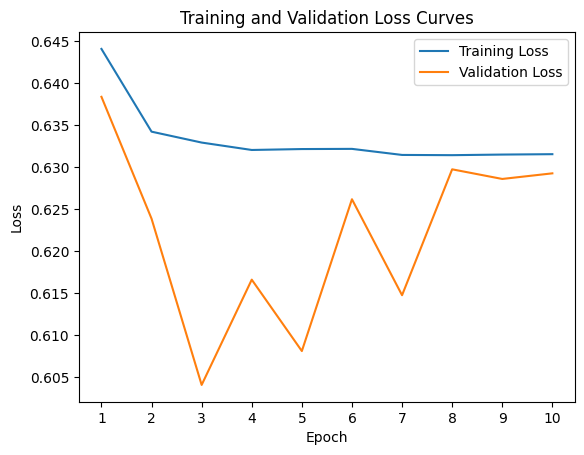

In [35]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, 11), training_losses, label='Training Loss')
plt.plot(range(1, 11), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Set x-axis to have increments of 1
plt.xticks(range(1, 11))

plt.show()

In [21]:
model.load_state_dict(torch.load('C:/Users/ruben/OneDrive/Desktop/GNN/GAT_3_epochs.pth'))
print(f'Model loaded from C:/Users/ruben/OneDrive/Desktop/GNN/GAT_3_epochs.pth')

y_test, y_test_pred_proba, test_loss = test(test_loader)
ap_test = average_precision_score(y_test, y_test_pred_proba)
roc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Average precision testing set: {ap_test:.4f}, ROC AUC testing set: {roc_test:.4f}')

Model loaded from C:/Users/ruben/OneDrive/Desktop/GNN/GAT_3_epochs.pth


100%|██████████| 98/98 [00:09<00:00, 10.72it/s]

Average precision testing set: 0.0061, ROC AUC testing set: 0.5000
